In [2]:
dbUrl = "jdbc:sqlserver://114.55.148.101:1433;databaseName=jiaowu"
df = spark.read.jdbc(dbUrl,"view_stu_course_mark",properties={"user":"wangpeng","password":"wangpeng2018!*swjtudean"})
df.createOrReplaceTempView("view_stu_course_mark")

In [62]:
data = spark.sql("select DISTINCT(m1.student_id),m1.course_name as code1,m2.course_name as code2, \
m3.course_name as code3,m4.course_name as code4,m5.course_name as code5,m6.course_name as code6, \
m1.mark as mark1,m2.mark as mark2,m3.mark as mark3,m4.mark as mark4,m5.mark as mark5,m6.mark as mark6, \
m1.speciality_code,m1.college_code  \
from view_stu_course_mark m1 \
join view_stu_course_mark m2 on m1.student_id=m2.student_id \
join view_stu_course_mark m3 on m2.student_id=m3.student_id \
join view_stu_course_mark m4 on m3.student_id=m4.student_id \
join view_stu_course_mark m5 on m4.student_id=m5.student_id \
join view_stu_course_mark m6 on m5.student_id=m6.student_id \
where \
m1.course_code='0121000' and m2.course_code='6010500' and m3.course_code='6011310'  \
and m4.course_code='0320120' and m5.course_code='8010210' and m6.course_code='0130700' \
and m1.speciality_code='0101' and m2.speciality_code='0101' and m3.speciality_code='0101' \
and m4.speciality_code='0101' and m5.speciality_code='0101' and m6.speciality_code='0101'")

In [4]:
from pyspark.sql.functions import *

In [63]:
data.createOrReplaceTempView("mark")

In [148]:
data.show(5,False)

+----------+--------------------------+--------------------------+-------------------------+-------------------------+-----+---------------------------+-----+-----+-----+-----+-----+-----+---------------+------------+
|student_id|code1                     |code2                     |code3                    |code4                    |code5|code6                      |mark1|mark2|mark3|mark4|mark5|mark6|speciality_code|college_code|
+----------+--------------------------+--------------------------+-------------------------+-------------------------+-----+---------------------------+-----+-----+-----+-----+-----+-----+---------------+------------+
|19990520  |建筑材料                      |线性代数B                     |高等数学Ⅰ                    |工程测量AⅡ                   |英语Ⅰ  |土力学B                       |7    |9    |3    |8    |2    |9    |0101           |01          |
|20011181  |建筑材料A                     |线性代数B                     |高等数学Ⅰ                    |工程测量AⅡ                   |英语Ⅰ  |土力学B

In [169]:
marks = spark.sql("select student_id,mark1,mark2,mark3,mark4,mark5,( case  when mark6<3 then 0 else 1 end) as result from mark")
marks.cache()
marks.show(5)

+----------+-----+-----+-----+-----+-----+------+
|student_id|mark1|mark2|mark3|mark4|mark5|result|
+----------+-----+-----+-----+-----+-----+------+
|  19990520|    7|    9|    3|    8|    2|     1|
|  20011181|    6|    8|    0|    1|    2|     0|
|  20011181|    6|    8|    0|    1|    0|     0|
|  20011181|    6|    8|    4|    1|    2|     0|
|  20011181|    6|    8|    4|    1|    0|     0|
+----------+-----+-----+-----+-----+-----+------+
only showing top 5 rows



In [170]:
marks = marks.dropDuplicates(['student_id'])
print(marks.count())
marks.show(5)

8567
+----------+-----+-----+-----+-----+-----+------+
|student_id|mark1|mark2|mark3|mark4|mark5|result|
+----------+-----+-----+-----+-----+-----+------+
|  19990520|    7|    9|    3|    8|    2|     1|
|  20011181|    6|    8|    0|    1|    2|     0|
|  20011197|    6|    1|    5|    9|    1|     1|
|  20011271|    9|    1|    3|    6|    3|     0|
|  20011281|    8|   10|   10|    7|    8|     1|
+----------+-----+-----+-----+-----+-----+------+
only showing top 5 rows



In [66]:
# 保存为文本
marks.coalesce(1).write.csv('mark-data-all-cls','overwrite')

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [171]:
# 转为pandas的 DataFrame,方便操作
df = marks.toPandas()
df.head()

,student_id,mark1,mark2,mark3,mark4,mark5,result
0,19990520,7,9,3,8,2,1
1,20011181,6,8,0,1,2,0
2,20011197,6,1,5,9,1,1
3,20011271,9,1,3,6,3,0
4,20011281,8,10,10,7,8,1


In [2]:
# 准备数据集
X = df.iloc[:,1:6]
y = df['result']
print(X.shape)
print(y.shape)

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)
print(X_train.head())

NameError: name 'df' is not defined

In [167]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.neural_network import MLPClassifier

In [181]:
model = GaussianNB()
# model = MLPClassifier(solver='lbfgs', alpha=1e-3,   hidden_layer_sizes=(20,11,30))
model = model.fit(X_train,y_train)
y_pred = model.predict(X_test)
# score = model.score(X_test,y_test)
score = accuracy_score(y_test,y_pred)
print(score)
y_pred = model.predict(X_train)
score = model.score(X_test,y_test)
score = accuracy_score(y_train,y_pred)
print(score)

0.701672500972
0.692628418946


In [120]:
dot_data = tree.export_graphviz(model, out_file='mark.dot') 
# graph = graphviz.Source(dot_data)
# graph.render("mark")

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.utils import to_categorical

y_binary = to_categorical(y_train)

model = Sequential()
model.add(Dense(units=10, input_dim=5))
model.add(Activation("relu"))
model.add(Dense(units=30))
model.add(Activation("relu"))
model.add(Dropout(0.4))
model.add(Dense(units=10))
model.add(Activation("relu"))
# model.add(Dense(units=20))
# model.add(Activation("relu"))
# model.add(Dense(units=30))
# model.add(Activation("relu"))
# model.add(Dense(units=20))
# model.add(Activation("relu"))
model.add(Dense(units=11))
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.fit(X_train, y_binary, epochs=1)

loss_and_metrics = model.evaluate(X_train, y_binary)

print(loss_and_metrics)

Using TensorFlow backend.


NameError: name 'y_train' is not defined

In [3]:
df = pd.read_csv('./mark-data-cls/mark.csv')
# 准备数据集
X = df.iloc[:,1:6]
y = df.iloc[:,6]
print(X.shape)
print(y.shape)

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)
print(X_train.head())

(8566, 5)
(8566,)
(5996, 5)
      80.0  89.0  67.0  82.0  64.0
8282  77.0  74.0  70.0  73.0  68.0
1073  80.0  60.0  62.0  86.0  66.0
8297  63.0  60.0  75.0  60.0  66.0
4358  92.0  99.0  85.0  78.0  57.0
6124  74.0  78.0  71.0  75.0  71.0


In [134]:
from sklearn.feature_selection import *
from sklearn.ensemble import ExtraTreesClassifier

In [135]:
clf = ExtraTreesClassifier()
clf = clf.fit(X, y)
clf.feature_importances_

array([ 0.18288969,  0.21727588,  0.21938162,  0.15215576,  0.22829706])

In [5]:
import matplotlib.pyplot as plt

{1: 1948, 7: 778, 10: 761, 5: 544, 9: 733, 0: 1159, 6: 598, 3: 345, 2: 406, 4: 794, 8: 500}


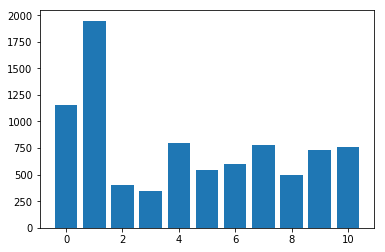

In [7]:

dy = {}
for i in y:
    dy[i] = dy.get(i,0)+1
print(dy)
xs = dy.keys()
ys = dy.values()
plt.bar(xs,ys)
plt.show()

In [7]:
%pylab inline
%load_ext memory_profiler
from pomegranate import BayesianNetwork
import seaborn, time
seaborn.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


In [9]:
X = numpy.random.randint(2, size=(2000, 7))
X[:,3] = X[:,1]
X[:,6] = X[:,1]

X[:,0] = X[:,2]

X[:,4] = X[:,5]

model = BayesianNetwork.from_samples(X, algorithm='exact')
print(model.structure)
# model.plot()

((), (), (0,), (1,), (), (4,), (3,))


In [10]:

ddd = df.iloc[:100,1:6]
model = BayesianNetwork.from_samples(ddd, algorithm='greedy')
print(model.structure)

((), (), (), (), ())
